# Robotic Systems 1 - Homework 2

## Modeling

In [ ]:
import numpy as np # Linear Algebra
import pinocchio as pin # Pinocchio library
import os
import time
import helpers as hp
import proxsuite
import matplotlib.pyplot as plt

from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.visualize import MeshcatVisualizer

VISUALIZER = MeshcatVisualizer

In [ ]:
def load_franka():
  current_path = os.path.abspath('') # where the folder `robot` is located at
  robot_path = os.path.join(current_path, "robot")

  robot = RobotWrapper.BuildFromURDF(os.path.join(robot_path, "franka.urdf"), package_dirs = robot_path)

  return robot

In [ ]:
def step_world(model, data, t_q, t_qdot, t_tau, t_dt):
  
  qdotdot = pin.aba(model, data, t_q, t_qdot, t_tau)
  q_dot = t_qdot + qdotdot*t_dt
  q_dot = np.clip(q_dot, -model.velocityLimit, model.velocityLimit)
  q = pin.integrate(model, t_q, q_dot*t_dt)
  q = np.clip(q, model.lowerPositionLimit, model.upperPositionLimit)
  
  return q, q_dot

In [ ]:
robot = load_franka()

model = robot.model
data = robot.data
end_effector = model.getFrameId("panda_ee")

robot.setVisualizer(VISUALIZER())
robot.initViewer()
robot.loadViewerModel("pinocchio")

robot.display(pin.randomConfiguration(model))

### Task-Space Trajectories

Trajectories were generated in the task space for the end effector to follow

- Decoupled trajectory (separate movement for the orientation and the translation) with simple time scaling
- The above with third order polynomials for time scaling

In [ ]:
# def get_Twd(start, goal, t_t, T):
#   return pin.SE3.Interpolate(start, goal, min(1, t_t/T))

def get_Twd_linear(start, goal, t_t, T):
  Twd = pin.SE3.Interpolate(start, goal, min(1, t_t/T))
  Twd.translation = hp.interpolate_translation(start.translation, goal.translation, min(1,t_t/T))
  return Twd

def get_Twd_qubic(start, goal, t_t, T):
  s = 3*(t_t/T)**2 -2*(t_t/T)**3
  Twd = pin.SE3.Interpolate(start, goal, s)
  Twd.translation = hp.interpolate_translation(start.translation, goal.translation, s)
  return Twd

## Task-Space Controller

The implemented controller is a feedback PID controller witch utilizes the robots dynamics equations expressed in the task-space.
The error is computed independently for the translation and the orientation of the end effector. Also a regularization task has been included to keep the joints as close to the middle of the operating area as possible.


In [137]:
def compute_error(Td, Tb):
  error = pin.log(Td * pin.SE3.inverse(Tb))
  error.linear = Td.translation - Tb.translation

  return error.vector

In [ ]:
prev_error = None
sum_error = 0.
init = True



def controller(model, data, t_q, t_qdot, t_Twd, t_dt, Kp=100., Ki=1000., Kd= 100.):
    global prev_error
    global sum_error
    global init

    pin.crba(model, data, t_q)
    pin.nonLinearEffects(model, data, t_q, t_qdot)
    J = pin.computeFrameJacobian(model, data, t_q, end_effector, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
    dJ = pin.getFrameJacobianTimeVariation(model, data, end_effector, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
    J_Tpinv = hp.damped_pseudoinverse(J.T)
    J_pinv = hp.damped_pseudoinverse(J)
    

    hp.fk_all(model, data, t_q)
    Twb = data.oMf[end_effector].copy()
    error = compute_error(t_Twd, Twb)

    if init:
        prev_error = np.copy(error)
        init = False

    sum_error += (error * t_dt)

    Lamda = J_Tpinv @ data.M @ J_pinv
    hta = J_Tpinv @ data.nle - Lamda @ dJ @ t_qdot
    F_w = Lamda@(Kp*error + Ki*sum_error + Kd*(error-prev_error)/t_dt) + hta
    prev_error = np.copy(error)

    #Null space controller - regularization
    q_target = (model.upperPositionLimit - model.lowerPositionLimit) / 2. + model.lowerPositionLimit
    t_reg = 1000. * (q_target - t_q)
    
    tau = J.T @ F_w + (np.eye(model.nv) - J.T @ J_Tpinv) @ t_reg

    return tau
  
  

## Simulation

Final position error SE(3) matrix:
  R =
           1  2.07568e-07  -2.0176e-07
-2.07568e-07            1  2.84681e-07
  2.0176e-07 -2.84681e-07            1
  p = -3.00945e-06  3.68503e-06 -1.51895e-06



(0.0, 10001.0)

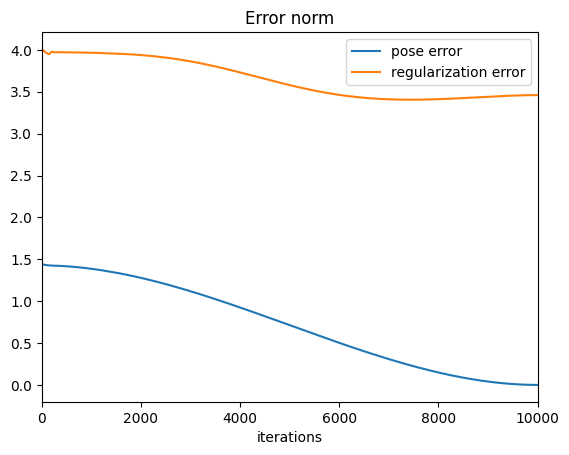

In [136]:
#simulation variables initialization
T = 10.
dt = 0.001
K = int(T/dt) + 1
prev_error = None
sum_error = 0.
init = True
t = 0
k = 0

error_ = []
reg_error_ = []
q_reg = (model.upperPositionLimit - model.lowerPositionLimit) / 2. + model.lowerPositionLimit

q = np.zeros(model.nv)
qdot = np.zeros(model.nv)
tau = np.zeros(model.nv)

pin.seed(1023)
#1023 null and no null
#6,2, 
#109453

#initial configuration
q = pin.randomConfiguration(model, model.lowerPositionLimit, model.upperPositionLimit)
hp.fk_all(model,data,q)
T_start = data.oMf[end_effector].copy()

#target configuration 
qt = pin.randomConfiguration(model, model.lowerPositionLimit, model.upperPositionLimit)
hp.fk_all(model,data, qt)
T_end = data.oMf[end_effector].copy()
robot.display(qt)#apply the target configuration and display it for 1 sec
time.sleep(1)

# T_end = T_start.copy()
# T_end.translation = T_start.translation + [0.5,-0.1,+0.4]
# T_end.rotation = hp.RotZ(np.pi/2) @  T_start.rotation

hp.fk_all(model,data,q)#reapply the initial configuration and display it for 1 sec before the simulation starts
robot.display(q)
time.sleep(1)

for k in range(K):
  #get the task-space trajectory
  Twd = get_Twd_qubic(T_start, T_end, t, T)

  #apply the controller to compute the desired tau
  tau = controller(model, data, q, qdot, Twd, dt, 10000., 10., 100.)

  #apply the computed tau to the robot's joints
  q , qdot  = step_world(model, data, q, qdot, tau, dt)

  #visualization
  if np.mod(k, 100)==0:
    robot.display(q)

  error_.append(np.linalg.norm(compute_error(T_end, data.oMf[end_effector])))
  reg_error_.append(np.linalg.norm(q_reg-q))

  t += dt
  k +=1
  
print("Final position error SE(3) matrix:")
print(pin.exp(compute_error(T_end, data.oMf[end_effector])))

plt.plot(error_)
plt.title("Error norm")
plt.xlim([0, K])

plt.plot(reg_error_)
plt.legend(["pose error","regularization error"])
plt.xlabel("iterations")
plt.xlim([0, K])
